<a href="https://colab.research.google.com/github/ghommidhWassim/GNN-variants/blob/main/nodeFeatCorrGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torchvision
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.6.0+cu124
12.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [2]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
import time
import json
# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_sparse import spmm
# import pyg_lib
import torch_sparse
from torch_geometric.utils import to_networkx
from sklearn.metrics import f1_score

# PyTorch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid,Amazon
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch.profiler import profile, record_function, ProfilerActivity
import os.path as osp
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GraphSAGE
from sklearn.metrics import accuracy_score
from transformers import AutoModelForCausalLM
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
def clean_gpu_memory():
    """Cleans GPU memory without fully resetting the CUDA context"""
    import gc
    gc.collect()  # Python garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # PyTorch cache
        torch.cuda.reset_peak_memory_stats()  # Reset tracking
        print(f"Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

def f1_micro(data, mask):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred[mask.to(device)].cpu().numpy()
    return f1_score(y_true, y_pred, average='micro')


In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Initial allocated memory: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

Initial allocated memory: 83.56 MB


In [125]:
num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

Using device: cuda
Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


In [122]:


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


In [121]:
def train(data, mask):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out = model(data.x, data.edge_index)  # Perform a single forward pass.
  loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test(data, mask):
  model.eval()
  out = model(data.x.to(device), data.edge_index.to(device))
  pred = out.argmax(dim=1)
  correct = pred[mask.to(device)] == data.y[mask.to(device)]
  acc = int(correct.sum()) / int(mask.sum())
  return acc

In [120]:
import torch
from torch_geometric.utils import subgraph, to_networkx
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

def compute_corr_matrix(features):
    # features: [num_nodes, num_features] numpy array
    norm_features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-8)
    corr_matrix = cosine_similarity(norm_features)
    return corr_matrix

def select_least_correlated_nodes(nodes_idx, features_np, num_select):
    # nodes_idx: list of node indices (int) to consider neighbors for
    # features_np: numpy array of features of those nodes
    n = len(nodes_idx)
    corr_matrix = compute_corr_matrix(features_np)

    selected_indices = set()
    for i in range(n):
        # sort neighbors by ascending correlation (less correlated first)
        corr_values = corr_matrix[i]
        sorted_indices = np.argsort(np.abs(corr_values))  # abs because correlation ranges [-1,1]
        # remove self index
        sorted_indices = sorted_indices[sorted_indices != i]

        # select top-k least correlated neighbors (or all available)
        k = min(num_select, len(sorted_indices))
        for idx in sorted_indices[:k]:
            selected_indices.add(nodes_idx[idx])
    return list(selected_indices)

def custom_partition(data, num_neighbors=4, num_hops=2):
    all_nodes = set(range(data.num_nodes))
    used_nodes = set()
    subgraphs = []

    x_np = data.x.cpu().numpy()

    while len(used_nodes) < data.num_nodes:
        # Remaining nodes to pick from
        candidate_nodes = list(all_nodes - used_nodes)
        if not candidate_nodes:
            break

        # Pick a random seed node not used yet
        seed = np.random.choice(candidate_nodes)
        current_hop_nodes = [seed]
        selected_nodes = set([seed])  # Include starting node

        for hop in range(num_hops):
            neighbors = []
            # get neighbors of current hop nodes
            for node in current_hop_nodes:
                neigh = data.edge_index[1][data.edge_index[0] == node].cpu().numpy()
                neighbors.extend(neigh.tolist())
            neighbors = list(set(neighbors) - used_nodes - selected_nodes)
            if not neighbors:
                break

            # get features of neighbors and current hop nodes combined
            nodes_to_consider = current_hop_nodes + neighbors
            feats = x_np[nodes_to_consider]

            # select least correlated neighbors among neighbors
            selected_neighbors = select_least_correlated_nodes(neighbors, x_np[neighbors], num_neighbors)

            selected_nodes.update(selected_neighbors)
            current_hop_nodes = selected_neighbors

        used_nodes.update(selected_nodes)

        # Build subgraph with selected nodes
        sub_nodes = list(selected_nodes)
        edge_index_sub, _ = subgraph(sub_nodes, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)

        x_sub = data.x[sub_nodes]
        y_sub = data.y[sub_nodes]
        mask_sub = {}
        for key in ['train_mask', 'val_mask', 'test_mask']:
            if hasattr(data, key):
                mask = getattr(data, key)
                mask_sub[key] = mask[sub_nodes]

        subgraph_data = Data(
            x=x_sub,
            edge_index=edge_index_sub,
            y=y_sub,
            **mask_sub
        )
        subgraphs.append(subgraph_data)

    return subgraphs


In [135]:
subgraphs = custom_partition(data, num_neighbors=300, num_hops=64)

from torch_geometric.loader import DataLoader
loader = DataLoader(subgraphs, batch_size=128, shuffle=True)


In [99]:
data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
loader1 = ClusterLoader(cluster_data, batch_size=128, shuffle=True)


Computing METIS partitioning...
Done!


In [11]:
def avg_neighbors_per_node(subgraphs):
    total_neighbors = 0
    total_nodes = 0

    for g in subgraphs:
        edge_index = g.edge_index
        num_nodes = g.num_nodes
        num_edges = edge_index.size(1)
        # Each edge connects two nodes, but we count for undirected graph
        total_neighbors += num_edges
        total_nodes += num_nodes

    avg = total_neighbors / total_nodes
    print(f"Average neighbors per node: {avg:.2f}")
    return avg



In [12]:
def train_batch(loader):
    model.train()
    total_loss = 0
    i = 1
    for sub_data in loader:
        sub_data = sub_data.to(device)
        batch_mem = sum(t.element_size() * t.nelement() for t in [sub_data.x, sub_data.edge_index, sub_data.y])
        #print(f"Batch {i}: {batch_mem/1024**2:.2f} MB cluster data")

        out = model(sub_data.x, sub_data.edge_index)
        #print(f"  + Forward pass: {torch.cuda.max_memory_allocated()/1024**2:.2f} MB")
        loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        i += 1
    return total_loss / i  # Optional: average loss


In [137]:
def estimate_subgraph_memory(subgraph):
    bytes_per_float = 4  # float32
    bytes_per_int = 4    # int32

    num_nodes = subgraph.num_nodes
    num_edges = subgraph.edge_index.size(1)
    num_features = subgraph.x.size(1)

    feature_memory = num_nodes * num_features * bytes_per_float
    edge_memory = 2 * num_edges * bytes_per_int
    label_memory = num_nodes * bytes_per_int

    total_memory_bytes = feature_memory + edge_memory + label_memory
    total_memory_MB = total_memory_bytes / (1024 ** 2)

    return total_memory_MB

memories = [estimate_subgraph_memory(g) for g in subgraphs]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")

Average subgraph memory: 2.02 MB
Average neighbors per node: 4.49
Number of subgraphs: 19


In [128]:

#model = GCN(hidden_channels=64).to(device)
model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)
res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  end_time = time.time()
  training.append(end_time - start_time)
  print(f"Training time: {end_time - start_time:.2f} seconds")


<IPython.core.display.Javascript object>

Memory after cleanup: 143.61 MB
Epoch: 010, Train Acc: 0.9333, Val Acc: 0.7280, Val F1 (micro): 0.7280
Epoch: 020, Train Acc: 0.9500, Val Acc: 0.7420, Val F1 (micro): 0.7420
Epoch: 030, Train Acc: 0.9500, Val Acc: 0.7560, Val F1 (micro): 0.7560
Epoch: 040, Train Acc: 0.9833, Val Acc: 0.7660, Val F1 (micro): 0.7660
Epoch: 050, Train Acc: 1.0000, Val Acc: 0.7640, Val F1 (micro): 0.7640
Epoch: 060, Train Acc: 1.0000, Val Acc: 0.7700, Val F1 (micro): 0.7700
Epoch: 070, Train Acc: 1.0000, Val Acc: 0.7780, Val F1 (micro): 0.7780
Epoch: 080, Train Acc: 1.0000, Val Acc: 0.7760, Val F1 (micro): 0.7760
Epoch: 090, Train Acc: 1.0000, Val Acc: 0.7700, Val F1 (micro): 0.7700
Epoch: 100, Train Acc: 1.0000, Val Acc: 0.7700, Val F1 (micro): 0.7700
Training time: 0.89 seconds
Memory after cleanup: 143.86 MB
Epoch: 010, Train Acc: 1.0000, Val Acc: 0.7680, Val F1 (micro): 0.7680
Epoch: 020, Train Acc: 1.0000, Val Acc: 0.7700, Val F1 (micro): 0.7700
Epoch: 030, Train Acc: 1.0000, Val Acc: 0.7680, Val F1 (

In [129]:
print(res)
print(sum(res)/10)

[0.759, 0.758, 0.757, 0.756, 0.755, 0.755, 0.752, 0.753, 0.753, 0.755]
0.7553


In [130]:
print(training)
print(sum(training)/10)

[0.8879518508911133, 0.7868518829345703, 0.7806694507598877, 0.778923749923706, 0.7782654762268066, 0.7859904766082764, 0.9130876064300537, 0.9701948165893555, 0.7968025207519531, 0.8072173595428467]
0.8285955190658569


In [90]:
test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

Test F1 Score (micro): 0.7440
Test test accuracy (micro):  0.7440


In [91]:
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


Allocated memory after tensor creation: 50.67 MB
Reserved memory after tensor creation: 118.00 MB
Peak allocated memory: 58.72 MB


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_pubmed_results.json", "w") as f:
    json.dump(metrics, f)

**cora dataset**

In [109]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
#subgraphs = custom_partition(data, num_neighbors=12, num_hops=3)

#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)

data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
#loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)


Memory after cleanup: 35.67 MB
Using device: cuda


/tmp/ipython-input-109-2746728292.py:17: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  cluster_data = ClusterData(data, num_parts=128)
Computing METIS partitioning...
Done!


In [81]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)

res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 49.66 MB
Epoch: 010, Train Acc: 0.9857, Val Acc: 0.7640, Val F1 (micro): 0.7640
Epoch: 020, Train Acc: 1.0000, Val Acc: 0.7860, Val F1 (micro): 0.7860
Epoch: 030, Train Acc: 1.0000, Val Acc: 0.8060, Val F1 (micro): 0.8060
Epoch: 040, Train Acc: 1.0000, Val Acc: 0.8020, Val F1 (micro): 0.8020
Epoch: 050, Train Acc: 1.0000, Val Acc: 0.7880, Val F1 (micro): 0.7880
Epoch: 060, Train Acc: 1.0000, Val Acc: 0.7920, Val F1 (micro): 0.7920
Epoch: 070, Train Acc: 0.9929, Val Acc: 0.7900, Val F1 (micro): 0.7900
Epoch: 080, Train Acc: 1.0000, Val Acc: 0.7840, Val F1 (micro): 0.7840
Epoch: 090, Train Acc: 1.0000, Val Acc: 0.7960, Val F1 (micro): 0.7960
Epoch: 100, Train Acc: 1.0000, Val Acc: 0.7780, Val F1 (micro): 0.7780
Training time: 8.61 seconds
Memory after cleanup: 49.79 MB
Epoch: 010, Train Acc: 0.9929, Val Acc: 0.7800, Val F1 (micro): 0.7800
Epoch: 020, Train Acc: 0.9929, Val Acc: 0.7800, Val F1 (micro): 0.7800
Epoch: 030, Train Acc: 0.9929, Val Acc: 0.7640, Val F1 (mi

In [82]:
print(res)
print(sum(res)/10)

[0.813, 0.816, 0.801, 0.798, 0.802, 0.805, 0.808, 0.792, 0.794, 0.778]
0.8007


In [83]:
print(training)
print(sum(training)/10)

[8.608620882034302, 8.570568323135376, 7.838213920593262, 8.394564390182495, 8.464603185653687, 8.151695728302002, 8.038593530654907, 8.353860139846802, 8.433150053024292, 7.900252819061279]
8.27541229724884


In [111]:
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in cluster_data]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")

Allocated memory after tensor creation: 35.67 MB
Reserved memory after tensor creation: 118.00 MB
Peak allocated memory: 50.67 MB
Average subgraph memory: 0.12 MB
Average neighbors per node: 2.12
Number of subgraphs: 848


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_Cora_results.json", "w") as f:
    json.dump(metrics, f)

**citeser dataset**

In [113]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
#subgraphs = custom_partition(data, num_neighbors=12, num_hops=3)

#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)

data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
#loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)

Memory after cleanup: 35.67 MB
Using device: cuda


/tmp/ipython-input-113-3016972498.py:17: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  cluster_data = ClusterData(data, num_parts=128)
Computing METIS partitioning...
Done!


In [114]:
memories = [estimate_subgraph_memory(g) for g in cluster_data]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")

Average subgraph memory: 0.37 MB


In [72]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)
res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 115.20 MB
Epoch: 010, Train Acc: 0.9500, Val Acc: 0.6700, Val F1 (micro): 0.6700
Epoch: 020, Train Acc: 0.9750, Val Acc: 0.6400, Val F1 (micro): 0.6400
Epoch: 030, Train Acc: 0.9833, Val Acc: 0.6660, Val F1 (micro): 0.6660
Epoch: 040, Train Acc: 0.9667, Val Acc: 0.6140, Val F1 (micro): 0.6140
Epoch: 050, Train Acc: 0.9833, Val Acc: 0.6480, Val F1 (micro): 0.6480
Epoch: 060, Train Acc: 0.9917, Val Acc: 0.6580, Val F1 (micro): 0.6580
Epoch: 070, Train Acc: 0.9750, Val Acc: 0.6640, Val F1 (micro): 0.6640
Epoch: 080, Train Acc: 0.9917, Val Acc: 0.6420, Val F1 (micro): 0.6420
Epoch: 090, Train Acc: 0.9667, Val Acc: 0.5840, Val F1 (micro): 0.5840
Epoch: 100, Train Acc: 0.9833, Val Acc: 0.6080, Val F1 (micro): 0.6080
Training time: 15.52 seconds
Memory after cleanup: 117.02 MB
Epoch: 010, Train Acc: 0.9917, Val Acc: 0.6540, Val F1 (micro): 0.6540
Epoch: 020, Train Acc: 0.9917, Val Acc: 0.6740, Val F1 (micro): 0.6740
Epoch: 030, Train Acc: 0.9917, Val Acc: 0.6300, Val F1 

In [73]:
print(res)
print(sum(res)/10)
print(training)
print(sum(training)/10)
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in subgraphs]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")


[0.617, 0.642, 0.638, 0.63, 0.636, 0.643, 0.652, 0.647, 0.64, 0.643]
0.6388
[15.523002862930298, 14.921468019485474, 14.882394075393677, 14.925318002700806, 15.512075185775757, 14.860661745071411, 14.884276151657104, 14.89121699333191, 15.43820309638977, 14.888725996017456]
15.072734212875366
Allocated memory after tensor creation: 117.02 MB
Reserved memory after tensor creation: 194.00 MB
Peak allocated memory: 129.82 MB
Average subgraph memory: 0.03 MB
Average neighbors per node: 1.50
Number of subgraphs: 1571


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_CiteSeer_results.json", "w") as f:
    json.dump(metrics, f)

**Amazon dataset**

In [115]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Amazon(
        root='data/Amazon',
        name='Computers',
        transform=T.Compose([
        NormalizeFeatures(),          # feature‑wise ℓ₂ normalisation
        RandomNodeSplit(              # ⇦ add a split transform
                split='train_rest',       # 10% val, 10% test by default
                num_val=0.1,
                num_test=0.1,
                num_splits=1,
            )
        ])
    )
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()

#subgraphs = custom_partition(data, num_neighbors=12, num_hops=3)

#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)

data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
#loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)

Memory after cleanup: 35.67 MB
Using device: cuda


/tmp/ipython-input-115-2133523359.py:30: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  cluster_data = ClusterData(data, num_parts=128)
Computing METIS partitioning...
Done!


In [116]:
memories = [estimate_subgraph_memory(g) for g in cluster_data]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")

Average subgraph memory: 0.33 MB


In [78]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)

res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 109.35 MB
Epoch: 010, Train Acc: 0.3869, Val Acc: 0.3993, Val F1 (micro): 0.3993
Epoch: 020, Train Acc: 0.6684, Val Acc: 0.6764, Val F1 (micro): 0.6764
Epoch: 030, Train Acc: 0.6923, Val Acc: 0.6996, Val F1 (micro): 0.6996
Epoch: 040, Train Acc: 0.7452, Val Acc: 0.7513, Val F1 (micro): 0.7513
Epoch: 050, Train Acc: 0.7722, Val Acc: 0.7716, Val F1 (micro): 0.7716
Epoch: 060, Train Acc: 0.7879, Val Acc: 0.7825, Val F1 (micro): 0.7825
Epoch: 070, Train Acc: 0.8041, Val Acc: 0.7978, Val F1 (micro): 0.7978
Epoch: 080, Train Acc: 0.8324, Val Acc: 0.8305, Val F1 (micro): 0.8305
Epoch: 090, Train Acc: 0.8374, Val Acc: 0.8364, Val F1 (micro): 0.8364
Epoch: 100, Train Acc: 0.8518, Val Acc: 0.8451, Val F1 (micro): 0.8451
Training time: 11.90 seconds
Memory after cleanup: 109.73 MB
Epoch: 010, Train Acc: 0.8562, Val Acc: 0.8495, Val F1 (micro): 0.8495
Epoch: 020, Train Acc: 0.8602, Val Acc: 0.8531, Val F1 (micro): 0.8531
Epoch: 030, Train Acc: 0.8653, Val Acc: 0.8589, Val F1 

In [79]:
print(res)
print(sum(res)/10)
print(training)
print(sum(training)/10)
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in loader]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")


[0.8385454545454546, 0.8618181818181818, 0.8785454545454545, 0.88, 0.8814545454545455, 0.888, 0.893090909090909, 0.893090909090909, 0.896, 0.8967272727272727]
0.8807272727272727
[11.895931482315063, 11.717468023300171, 11.613438844680786, 11.5549476146698, 11.324125528335571, 11.451564073562622, 11.456234216690063, 11.455196142196655, 11.404703140258789, 11.522497415542603]
11.539610648155213
Allocated memory after tensor creation: 109.73 MB
Reserved memory after tensor creation: 430.00 MB
Peak allocated memory: 374.09 MB
Average subgraph memory: 4.07 MB
Average neighbors per node: 3.78
Number of subgraphs: 1165


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_Amazon_results.json", "w") as f:
    json.dump(metrics, f)

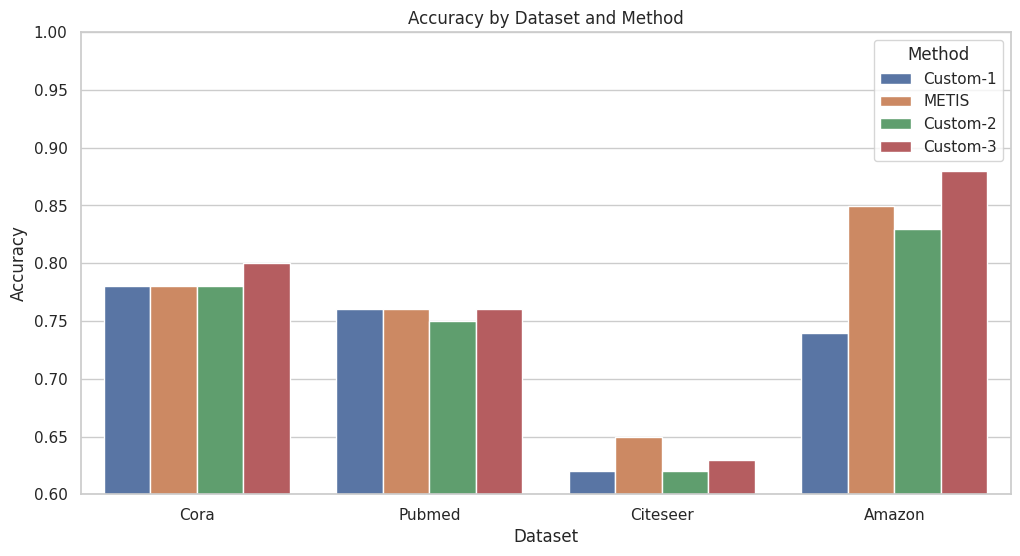

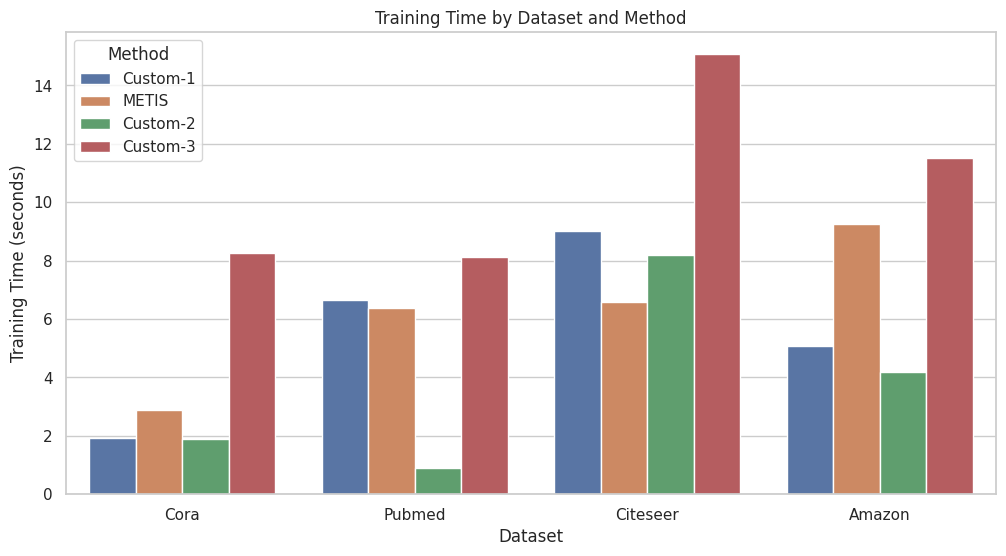

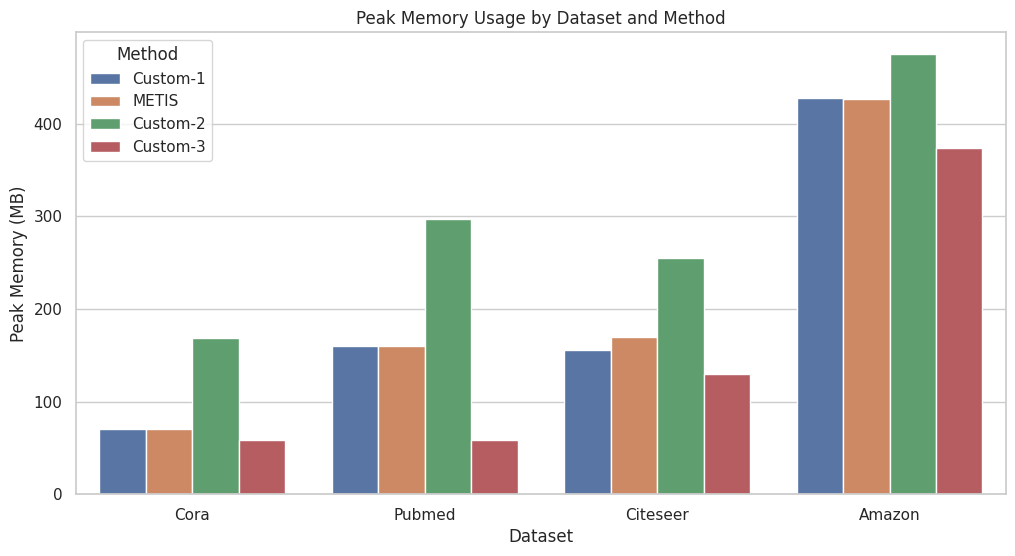

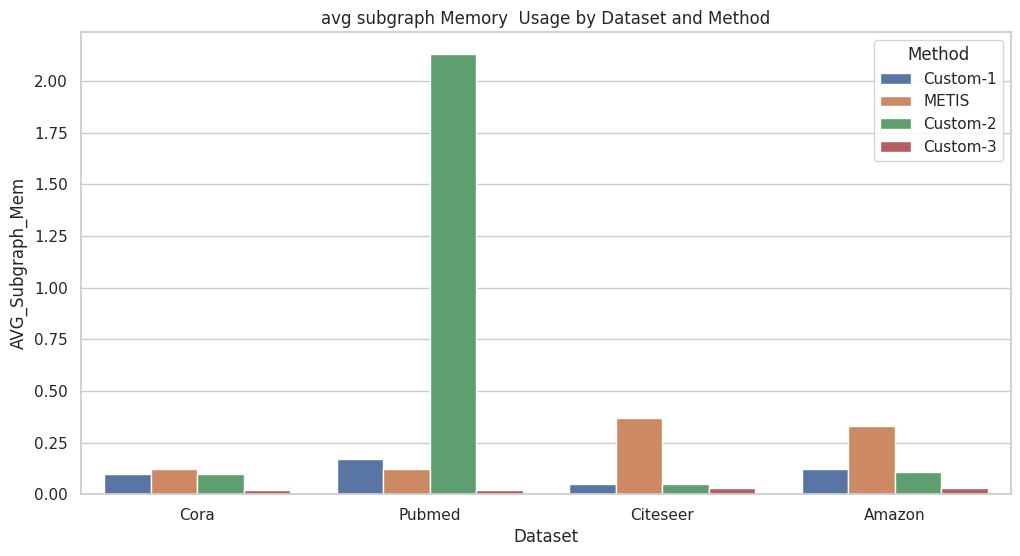

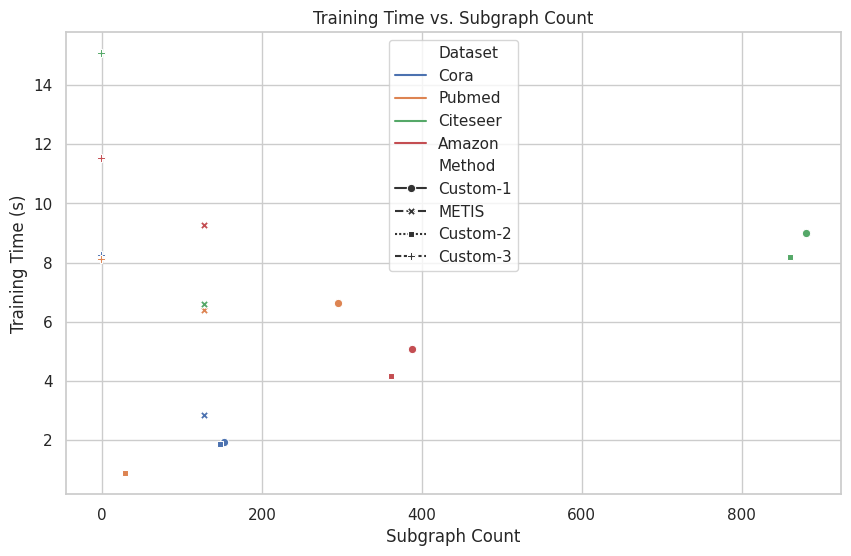

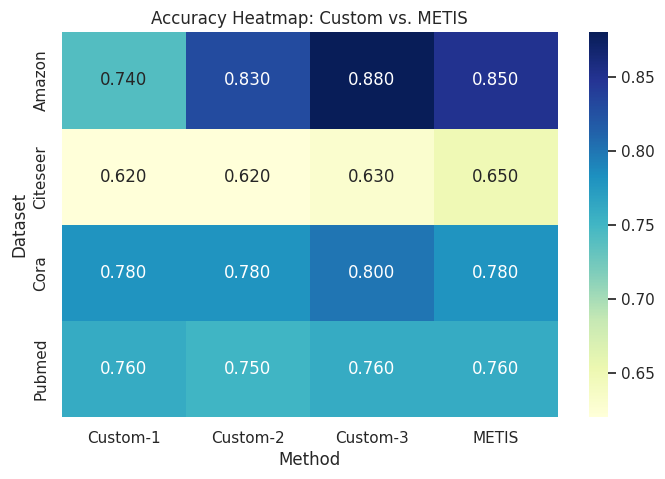

In [139]:
import pandas as pd

# Example results (replace with your actual values)
results = [
    # dataset, method, accuracy, training_time (s), peak_memory (MB), num_subgraphs, avg_subgraph_memory (MB)
    ("Cora", "Custom-1", 0.78, 1.94, 70.48, 152, 0.10),
    ("Cora", "METIS", 0.78, 2.87, 70.69, 128, 0.12),
    ("Cora", "Custom-2", 0.78, 1.89, 168.80, 147, 0.10),
    ("Cora", "Custom-3", 0.80, 8.27, 58.03, -1, 0.02),  # num_subgraphs missing for Custom-3

    ("Pubmed", "Custom-1", 0.76, 6.65, 159.85, 295, 0.17),
    ("Pubmed", "METIS", 0.76, 6.39, 160.35, 128, 0.12),
    ("Pubmed", "Custom-2", 0.75, 0.89, 297.64, 29, 2.13),
    ("Pubmed", "Custom-3", 0.76, 8.12, 58.72, -1, 0.02),  # num_subgraphs missing for Custom-3

    ("Citeseer", "Custom-1", 0.62, 9.00, 155.42, 880, 0.05),
    ("Citeseer", "METIS", 0.65, 6.60, 170.18, 128, 0.37),
    ("Citeseer", "Custom-2", 0.62, 8.20, 255.00, 860, 0.05),
    ("Citeseer", "Custom-3", 0.63, 15.07, 129.82, -1, 0.03),  # num_subgraphs missing for Custom-3

    ("Amazon", "Custom-1", 0.74, 5.08, 427.28, 388, 0.12),
    ("Amazon", "METIS", 0.85, 9.26, 426.65, 128, 0.33),
    ("Amazon", "Custom-2", 0.83, 4.18, 474.98, 361, 0.11),
    ("Amazon", "Custom-3", 0.88, 11.53, 374.09, -1, 0.03),  # num_subgraphs missing for Custom-3
]
df = pd.DataFrame(results, columns=["Dataset", "Method", "Accuracy", "TrainingTime", "PeakMemory", "SubgraphCount", "AVG_Subgraph_Mem"])
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="Accuracy", hue="Method")
plt.title("Accuracy by Dataset and Method")
plt.ylim(0.6, 1.0)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="TrainingTime", hue="Method")
plt.title("Training Time by Dataset and Method")
plt.ylabel("Training Time (seconds)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="PeakMemory", hue="Method")
plt.title("Peak Memory Usage by Dataset and Method")
plt.ylabel("Peak Memory (MB)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="AVG_Subgraph_Mem", hue="Method")
plt.title("avg subgraph Memory  Usage by Dataset and Method")
plt.ylabel("AVG_Subgraph_Mem")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SubgraphCount", y="TrainingTime", hue="Dataset", style="Method", markers=True)
plt.title("Training Time vs. Subgraph Count")
plt.xlabel("Subgraph Count")
plt.ylabel("Training Time (s)")
plt.show()
# Create pivot for heatmap
heatmap_df = df.pivot_table(index="Dataset", columns="Method", values="Accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap: Custom vs. METIS")
plt.show()


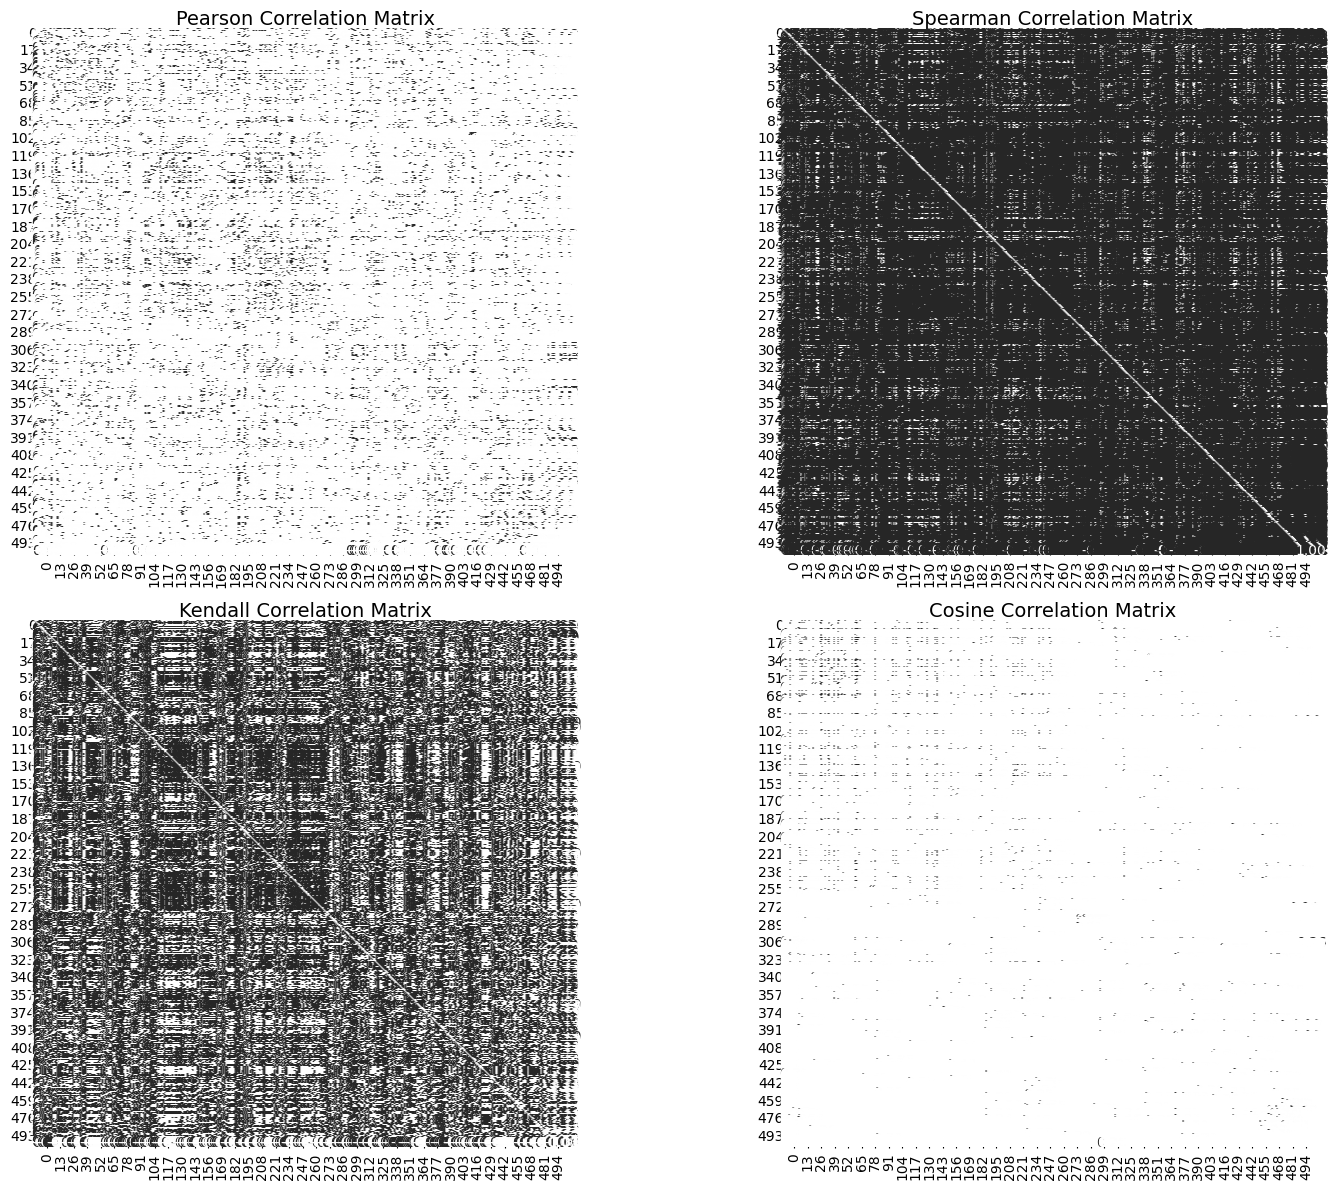

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create fake numeric data
np.random.seed(0)

features = data.x.cpu().numpy()  # Shape: (num_nodes, num_features)
df = pd.DataFrame(features)
# Step 2: Compute correlation/similarity matrices
df_numeric = df.select_dtypes(include=['number'])

correlations = {
    'Pearson': df_numeric.corr(method='pearson'),
    'Spearman': df_numeric.corr(method='spearman'),
    'Kendall': df_numeric.corr(method='kendall'),
    'Cosine': pd.DataFrame(
        cosine_similarity(df_numeric.T),
        index=df_numeric.columns,
        columns=df_numeric.columns
    )
}

# Step 3: Plot heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, (name, corr_matrix) in zip(axes, correlations.items()):
    sns.heatmap(corr_matrix, ax=ax, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar=False)
    ax.set_title(f'{name} Correlation Matrix', fontsize=14)

plt.tight_layout()
plt.show()
